#### Instructions:
- Download the dataset from Učilnica and perform data preprocessing (e.g. deal with
missing values).
- Use Jupyter notebook to run your code and write comments. Name your file Your-Surname_assignment1.ipynb.
- Write the code to fit the multiple linear regression in Python. Use the closed form solution.
- Split your dataset on train and test data. As the data is temporal do not perform random shuffle. Remove the Datum from the dataset. Your target variable is PM10.
- Test your linear regression on the dataset and compare it with the liear regression implemented in SciKit-learn.
- Diagnose your linear regression with the diagnostic plots (see Lecture 2).
- Comment on your results.
- Can you make some improvements to your linear regression fit?
- Is there something you can improve like transform your target/attributes or remove some attributes/instances (see correlations)? Maybe some x have a different relationship to y than linear. Try different things and refit the linear regression. Comment the results.

---

In [1]:
# Imports
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import calendar

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from itertools import combinations
from scipy import stats

#### Data loading and inspection

In [2]:
# Load data
data = pd.read_csv("podatki_PM.csv")

print(f"{data.shape[0]} rows and {data.shape[1]} columns in the dataset.\n")
print(f"Columns in the dataset:\n{list(data.columns)}\n")
print(f"First few rows of the dataset:")
display(data.head())


# Check data types of columns
print(f"Data types of each column:\n{data.dtypes}\n")

# Get number of missing values per column
missing_values = data.isnull().sum().sort_values(ascending=False)
print(f"Missing values per column:\n{missing_values}\n")

missing_values_percentage = (missing_values / len(data)) * 100
print(f"Percentage of missing values per column:\n{missing_values_percentage}\n")

# Basic statistics to determine whether data looks plausible
for column in data.columns:
    if data[column].dtype == "float64":
        mean_val = data[column].mean()
        min_val = data[column].min()
        max_val = data[column].max()
        std_val = data[column].std()

        print(f"Column: {column}")
        print(f"-> Mean: {mean_val:.2f}")
        print(f"-> Min: {min_val:.2f}")
        print(f"-> Max: {max_val:.2f}")
        print(f"-> Std: {std_val:.2f}\n")

1213 rows and 12 columns in the dataset.

Columns in the dataset:
['Datum', 'Glob_sevanje_mean', 'Hitrost_vetra_mean', 'Sunki_vetra_max', 'Padavine_sum', 'Vlaga_mean', 'Temperatura_Krvavec_mean', 'Temperatura_lokacija_mean', 'PM10', 'PM_vceraj', 'sinD', 'cosD']

First few rows of the dataset:


,Datum,Glob_sevanje_mean,Hitrost_vetra_mean,Sunki_vetra_max,Padavine_sum,Vlaga_mean,Temperatura_Krvavec_mean,Temperatura_lokacija_mean,PM10,PM_vceraj,sinD,cosD
0,2013-01-02,0.125,0.6750,2.9,0.0,79.1750,-2.9875,3.2000,44.3,51.4,0.034899,0.999391
1,2013-01-03,0.375,0.7375,2.6,0.0,93.5625,-4.5250,2.8750,49.0,44.3,0.052336,0.998630
2,2013-01-04,0.875,0.8875,3.2,0.0,93.3000,2.9625,0.6875,61.3,49.0,0.069756,0.997564
3,2013-01-05,0.750,1.0000,4.5,0.0,94.2625,2.9875,0.5875,38.9,61.3,0.087156,0.996195
4,2013-01-06,0.250,0.5750,2.3,0.0,87.6500,-0.2500,3.1625,30.3,38.9,0.104528,0.994522


Data types of each column:
Datum                         object
Glob_sevanje_mean            float64
Hitrost_vetra_mean           float64
Sunki_vetra_max              float64
Padavine_sum                 float64
Vlaga_mean                   float64
Temperatura_Krvavec_mean     float64
Temperatura_lokacija_mean    float64
PM10                         float64
PM_vceraj                    float64
sinD                         float64
cosD                         float64
dtype: object

Missing values per column:
PM_vceraj                    33
Datum                         0
Hitrost_vetra_mean            0
Glob_sevanje_mean             0
Sunki_vetra_max               0
Padavine_sum                  0
Temperatura_Krvavec_mean      0
Vlaga_mean                    0
Temperatura_lokacija_mean     0
PM10                          0
sinD                          0
cosD                          0
dtype: int64

Percentage of missing values per column:
PM_vceraj                    2.720528
Datum     

---

#### Preprocessing and data cleaning

In [3]:
# Convert column 'Datum' to datetime
data["Datum"] = pd.to_datetime(data["Datum"])
print(f"New data type of 'Datum': {data['Datum'].dtypes}")

# Fill missing values in the column 'PM_vceraj' with previous day's value
data["PM_vceraj"] = data["PM_vceraj"].ffill()
print(f"\nMissing values:\n{data.isnull().sum()}")

# We'll keep 'Datum' for time-based splits, but it won't be a model feature.

New data type of 'Datum': datetime64[ns]

Missing values:
Datum                        0
Glob_sevanje_mean            0
Hitrost_vetra_mean           0
Sunki_vetra_max              0
Padavine_sum                 0
Vlaga_mean                   0
Temperatura_Krvavec_mean     0
Temperatura_lokacija_mean    0
PM10                         0
PM_vceraj                    0
sinD                         0
cosD                         0
dtype: int64


---

#### Helper functions

In [ ]:
def scale_features(
    X_train: np.ndarray, X_test: np.ndarray
) -> tuple[np.ndarray, np.ndarray, StandardScaler]:
    """Standardize features.

    Returns
    -------
    X_train_std : np.ndarray
        Scaled training data
    X_test_std : np.ndarray
        Scaled test data
    scaler : StandardScaler
        Fitted scaler
    """
    scaler = StandardScaler()

    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)

    return X_train_std, X_test_std, scaler


def closed_form_regression(
    X: np.ndarray, y: np.ndarray, alpha: float = 0.0
) -> np.ndarray:
    """
    Closed-form linear regression with optional Ridge regularization (L2).
    alpha = 0: ordinary least squares, alpha > 0: Ridge.

    Parameters
    ----------
    X : np.ndarray
        Feature matrix (standardized)
    y : np.ndarray
        Target vector
    alpha : float
        Regularization strength
    """
    X_bias = np.hstack([np.ones((X.shape[0], 1)), X])  # add intercept term
    n_features = X_bias.shape[1]

    # Identity matrix for penalty
    I = np.eye(n_features)
    I[0, 0] = 0  # we do not penalize intercept

    # Closed-form solution
    beta = np.linalg.pinv(X_bias.T @ X_bias + alpha * I) @ X_bias.T @ y
    return beta


def predict(X: np.ndarray, beta: np.ndarray) -> np.ndarray:
    """Generate predictions using the model coefficients.

    Parameters
    ----------
    X : np.ndarray
        Feature matrix (standardized)
    beta : np.ndarray
        Model coefficients

    Returns
    -------
    y_pred : np.ndarray
        Predicted target values
    """
    X_bias = np.hstack([np.ones((X.shape[0], 1)), X])  # add intercept term
    return X_bias @ beta


def evaluate_predictions(
    y_true: np.ndarray, y_pred: np.ndarray
) -> tuple[float, float, float]:
    """Compute R2, RMSE and MAE metrics.

    Parameters
    ----------
    y_true : np.ndarray
        True target values
    y_pred : np.ndarray
        Predicted target values

    Returns
    -------
    r2 : float
        R-squared metric
    rmse : float
        Root Mean Squared Error
    mae : float
        Mean Absolute Error
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return r2, rmse, mae


def fit_and_evaluate(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    y_test: np.ndarray,
    alpha: float = 0.0,
) -> tuple[float, float, float]:
    """
    Scale features, fit closed-form regression, predict and evaluate.

    Parameters
    ----------
    X_train : np.ndarray
        Training feature matrix
    y_train : np.ndarray
        Training target vector
    X_test : np.ndarray
        Test feature matrix
    y_test : np.ndarray
        Test target vector
    alpha : float
        Regularization strength

    Returns
    -------
    r2 : float
        R-squared metric
    rmse : float
        Root Mean Squared Error
    mae : float
        Mean Absolute Error
    """
    X_train_std, X_test_std, _ = scale_features(X_train, X_test)
    beta = closed_form_regression(X_train_std, y_train, alpha=alpha)
    y_pred = predict(X_test_std, beta)

    return evaluate_predictions(y_test, y_pred)


def choose_alpha_time_series(X_train, y_train, alphas, val_frac=0.2):
    """
    Choose the best alpha (regularization strength) for Ridge using only past data.
    Splits the training window into sub-train and validation sets.

    Parameters
    ----------
    X_train : np.ndarray
        Training feature matrix
    y_train : np.ndarray
        Training target vector
    alphas : iterable of float
        Candidate alpha values
    val_frac : float
        Fraction of training data to use for validation

    Returns
    -------
    best_alpha : float
        Best alpha value found
    """
    n = X_train.shape[0]
    n_val = max(1, int(n * val_frac))
    n_subtrain = n - n_val

    # Split training data into sub-train and validation
    X_subtrain, y_subtrain = X_train[:n_subtrain], y_train[:n_subtrain]
    X_val, y_val = X_train[n_subtrain:], y_train[n_subtrain:]

    # Standardize features
    X_subtrain_std, X_val_std, _ = scale_features(X_subtrain, X_val)

    best_alpha, best_r2 = None, -np.inf
    for alpha in alphas:
        beta = closed_form_regression(X_subtrain_std, y_subtrain, alpha=alpha)
        y_val_pred = predict(X_val_std, beta)
        r2 = r2_score(y_val, y_val_pred)

        if r2 > best_r2:
            best_alpha, best_r2 = alpha, r2

    return best_alpha


from sklearn.preprocessing import PolynomialFeatures


def choose_alpha_time_series_lasso(X_train, y_train, alphas, val_frac=0.2):
    """
    Time-series safe alpha selection for Lasso.
    Splits the training window into sub-train and validation sets (no shuffling).
    """
    n = X_train.shape[0]
    n_val = max(1, int(n * val_frac))
    n_tr = n - n_val

    # Split training data into sub-train and validation
    X_subtrain, y_subtrain = X_train[:n_tr], y_train[:n_tr]
    X_val, y_val = X_train[n_tr:], y_train[n_tr:]

    # Standardize features
    X_subtrain_std, X_val_std, _ = scale_features(X_subtrain, X_val)

    best_alpha, best_r2 = None, -np.inf
    for alpha in alphas:
        lasso = Lasso(alpha=alpha, max_iter=100000, tol=1e-4)
        lasso.fit(X_subtrain_std, y_subtrain)
        y_val_pred = lasso.predict(X_val_std)
        r2 = r2_score(y_val, y_val_pred)

        if r2 > best_r2:
            best_alpha, best_r2 = alpha, r2

    return best_alpha


def expanding_window_cv(X, y, dates, model_func, alphas=None, transform_y=None):
    """
    Expanding-window time-series cross-validation.
    Reuses the same logic for OLS, Ridge and other models.
    """
    results = []
    last_split = {}

    first_train_start = pd.Timestamp("2013-01-01")
    first_train_end = pd.Timestamp("2013-12-31")
    month_starts = pd.date_range(start="2014-01-01", end=dates.iloc[-1], freq="MS")

    for test_start_date in month_starts:
        last_day = calendar.monthrange(test_start_date.year, test_start_date.month)[1]
        test_end_date = pd.Timestamp(
            test_start_date.year, test_start_date.month, last_day
        )

        train_mask = (dates >= first_train_start) & (dates <= first_train_end)
        test_mask = (dates >= test_start_date) & (dates <= test_end_date)
        if not test_mask.any():
            break

        X_train, X_test = X.loc[train_mask].values, X.loc[test_mask].values
        y_train, y_test = y.loc[train_mask].values, y.loc[test_mask].values
        if transform_y is not None:
            y_train, y_test = transform_y(y_train), transform_y(y_test)

        r2, rmse, mae, alpha_used = model_func(X_train, y_train, X_test, y_test, alphas)

        results.append(
            {
                "train_start": first_train_start.date(),
                "train_end": test_start_date - pd.Timedelta(days=1),
                "test_start": test_start_date.date(),
                "test_end": min(test_end_date, dates.iloc[-1]).date(),
                "R2": r2,
                "RMSE": rmse,
                "MAE": mae,
                "alpha": alpha_used,
            }
        )

        last_split = {
            "X_train": X_train,
            "y_train": y_train,
            "X_test": X_test,
            "y_test": y_test,
        }

        first_train_end = test_end_date

    return pd.DataFrame(results), last_split


def create_advanced_features(X_train, X_test):
    """
    Create nonlinear and interaction features:
    - Logarithmic transformation
    - Polynomial (2nd degree)
    - Pairwise interactions between original features
    """
    X_train = X_train.copy()
    X_test = X_test.copy()
    eps = 1e-6  # to avoid log(0)

    # Logarithmic transformation
    X_train_log = np.log1p(np.abs(X_train) + eps)
    X_test_log = np.log1p(np.abs(X_test) + eps)

    # Combine raw + log-transformed features
    X_train_basic = np.hstack([X_train, X_train_log])
    X_test_basic = np.hstack([X_test, X_test_log])

    # Polynomial expansion (2nd degree)
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_basic)
    X_test_poly = poly.transform(X_test_basic)

    # Pairwise interactions between original features
    interactions_train, interactions_test = [], []
    for i, j in combinations(range(X_train.shape[1]), 2):
        interactions_train.append((X_train[:, i] * X_train[:, j]).reshape(-1, 1))
        interactions_test.append((X_test[:, i] * X_test[:, j]).reshape(-1, 1))

    if interactions_train:
        X_train_inter = np.hstack(interactions_train)
        X_test_inter = np.hstack(interactions_test)
        X_train_final = np.hstack([X_train_poly, X_train_inter])
        X_test_final = np.hstack([X_test_poly, X_test_inter])
    else:
        X_train_final, X_test_final = X_train_poly, X_test_poly

    return X_train_final, X_test_final

---

#### Baseline model - OLS (raw target)

In [5]:
# Select columns (we exclude 'Datum' because it’s only used for splitting)
X_cols = [
    "Glob_sevanje_mean",
    "Hitrost_vetra_mean",
    "Sunki_vetra_max",
    "Padavine_sum",
    "Vlaga_mean",
    "Temperatura_Krvavec_mean",
    "Temperatura_lokacija_mean",
    "PM_vceraj",
    "sinD",
    "cosD",
]

X_all = data[X_cols].copy()
y_all = data["PM10"].copy()
dates = data["Datum"]

In [6]:
def ols_model(X_train, y_train, X_test, y_test, alphas=None):
    """Fit and evaluate standard OLS (no regularization)."""
    X_train_std, X_test_std, _ = scale_features(X_train, X_test)
    beta = closed_form_regression(X_train_std, y_train)
    y_pred = predict(X_test_std, beta)
    r2, rmse, mae = evaluate_predictions(y_test, y_pred)

    return r2, rmse, mae, None


ols_results_raw, last_split = expanding_window_cv(X_all, y_all, dates, ols_model)

display(ols_results_raw)

print("Average performance (OLS raw target):")
print(ols_results_raw[["R2", "RMSE", "MAE"]].mean())

,train_start,train_end,test_start,test_end,R2,RMSE,MAE,alpha
0,2013-01-01,2013-12-31,2014-01-01,2014-01-31,0.714560,8.647138,6.326186,None
1,2013-01-01,2014-01-31,2014-02-01,2014-02-28,0.073574,12.600374,9.906458,None
2,2013-01-01,2014-02-28,2014-03-01,2014-03-31,0.805242,6.594829,5.463909,None
3,2013-01-01,2014-03-31,2014-04-01,2014-04-30,0.566897,6.280802,4.955517,None
4,2013-01-01,2014-04-30,2014-05-01,2014-05-31,0.347938,5.769583,4.721550,None
5,2013-01-01,2014-05-31,2014-06-01,2014-06-30,0.639498,4.015852,3.296778,None
6,2013-01-01,2014-06-30,2014-07-01,2014-07-31,0.410792,4.034002,3.144431,None
7,2013-01-01,2014-07-31,2014-08-01,2014-08-31,0.251674,4.245264,3.092767,None
8,2013-01-01,2014-08-31,2014-09-01,2014-09-30,0.389020,5.759617,4.166160,None
9,2013-01-01,2014-09-30,2014-10-01,2014-10-31,0.603577,7.991756,6.311423,None


Average performance (OLS raw target):
R2     -0.507629
RMSE    8.554018
MAE     6.520202
dtype: float64


In [7]:
# Check that manual OLS matches sklearn on the final split
X_train = last_split["X_train"]
y_train = last_split["y_train"]
X_test = last_split["X_test"]
y_test = last_split["y_test"]

X_train_std, X_test_std, _ = scale_features(X_train, X_test)

# Manual OLS predictions
beta_hat = closed_form_regression(X_train_std, y_train)
y_pred_manual = predict(X_test_std, beta_hat)

# Sklearn LinearRegression
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train_std, y_train)
y_pred_lr = lr.predict(X_test_std)

# Compare metrics
print("Metrics comparison:")
print(
    f"Manual OLS:\tR2 = {r2_score(y_test, y_pred_manual):.6f}, RMSE = {np.sqrt(mean_squared_error(y_test, y_pred_manual)):.6f}, MAE = {mean_absolute_error(y_test, y_pred_manual):.6f}"
)
print(
    f"Sklearn LR:\tR2 = {r2_score(y_test, y_pred_lr):.6f}, RMSE = {np.sqrt(mean_squared_error(y_test, y_pred_lr)):.6f}, MAE = {mean_absolute_error(y_test, y_pred_lr):.6f}"
)

# Compare coefficients
print("\nFirst few coefficients:")
print(f"Manual OLS:\t{np.round(beta_hat[:5], 4)}")
print(f"Sklearn LR:\t{np.round(np.hstack([lr.intercept_, lr.coef_[:4]]), 4)}")

Metrics comparison:
Manual OLS:	R2 = 0.656282, RMSE = 5.326616, MAE = 4.335824
Sklearn LR:	R2 = 0.656282, RMSE = 5.326616, MAE = 4.335824

First few coefficients:
Manual OLS:	[25.0209  1.2763 -1.7692 -1.8563 -0.9099]
Sklearn LR:	[25.0209  1.2763 -1.7692 -1.8563 -0.9099]


##### Diagnostics

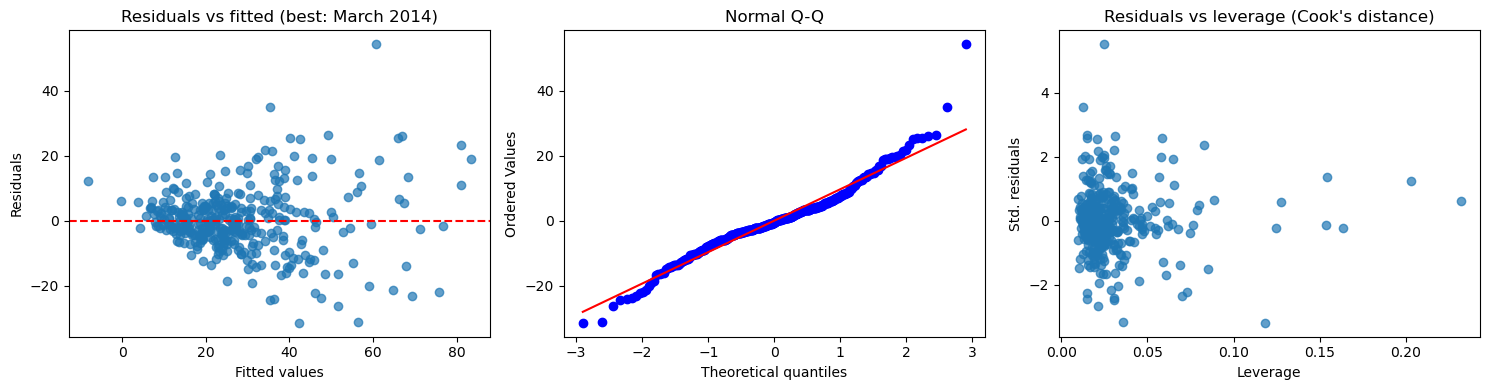

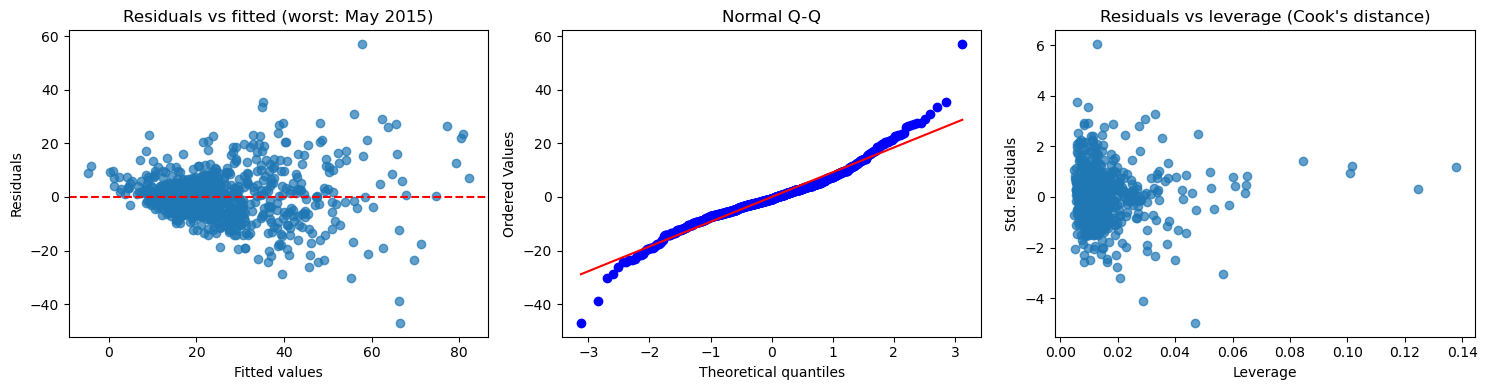

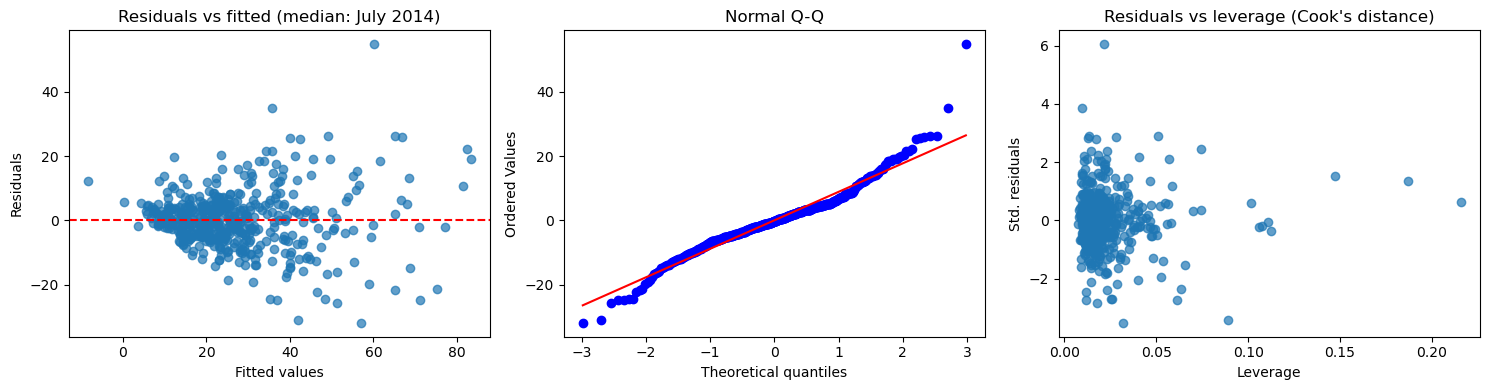

In [8]:
# We'll inspect residual patterns for a few test months
best_idx = ols_results_raw["R2"].idxmax()
worst_idx = ols_results_raw["R2"].idxmin()
median_idx = (ols_results_raw["R2"] - ols_results_raw["R2"].median()).abs().idxmin()

months_to_check = [[best_idx, "best"], [worst_idx, "worst"], [median_idx, "median"]]

for m_id, label in months_to_check:
    # Define month range
    test_start = pd.to_datetime(str(ols_results_raw.loc[m_id, "test_start"]))
    test_end = pd.to_datetime(str(ols_results_raw.loc[m_id, "test_end"]))

    # Training data up to previous month
    train_mask = (dates >= pd.Timestamp("2013-01-01")) & (
        dates <= test_start - pd.Timedelta(days=1)
    )
    test_mask = (dates >= test_start) & (dates <= test_end)

    X_train, y_train = X_all.loc[train_mask].values, y_all.loc[train_mask].values
    X_test, y_test = X_all.loc[test_mask].values, y_all.loc[test_mask].values

    # Fit using our closed-form regression
    X_train_std, X_test_std, _ = scale_features(X_train, X_test)
    beta = closed_form_regression(X_train_std, y_train)

    # Compute fitted values and residuals
    y_fitted = predict(X_train_std, beta)
    residuals = y_train - y_fitted

    # Use statsmodels for influence measures
    X_train_sm = sm.add_constant(X_train_std)
    model = sm.OLS(y_train, X_train_sm)
    influence = model.fit().get_influence()
    leverage = influence.hat_matrix_diag

    # PLOTS ----------------------------------------
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    month_label = test_start.strftime("%B %Y")

    # Residuals vs fitted
    axes[0].scatter(y_fitted, residuals, alpha=0.7, label="Residuals")
    axes[0].axhline(0, color="red", linestyle="--", label="Zero line")
    axes[0].set_title(f"Residuals vs fitted ({label}: {month_label})")
    axes[0].set_xlabel("Fitted values")
    axes[0].set_ylabel("Residuals")

    # Normal Q-Q plot
    stats.probplot(residuals, dist="norm", plot=axes[1])
    axes[1].set_title("Normal Q-Q")

    # Residuals vs leverage (Cook's distance)
    axes[2].scatter(leverage, residuals / np.std(residuals), alpha=0.7)
    axes[2].set_title("Residuals vs leverage (Cook's distance)")
    axes[2].set_xlabel("Leverage")
    axes[2].set_ylabel("Std. residuals")

    plt.tight_layout()
    plt.show()

# Note:
# The model coefficients come from my own closed-form implementation.
# I use statsmodels here only to compute residual influence measures (leverage, Cook's distance) for diagnostics, not for model fitting.
# Cook's distance contours were omitted because they fall far outside the visible residual range

---

### Improving the model

#### Log-transformed target - OLS (no regularization)

In [9]:
# We will apply a log-transform to the target variable to stabilize variance and reduce the influence of extreme PM10 values.
# This section uses the same OLS model but with y = log1p(PM10).
y_all_log = np.log1p(y_all)


def ols_model_log(X_train, y_train, X_test, y_test, alphas=None):
    """Fit and evaluate OLS on a log-transformed target."""
    X_train_std, X_test_std, _ = scale_features(X_train, X_test)
    beta = closed_form_regression(X_train_std, y_train)
    y_pred_log = predict(X_test_std, beta)

    # Back-transform predictions to original scale for evaluation
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test)

    r2, rmse, mae = evaluate_predictions(y_true, y_pred)
    return r2, rmse, mae, None


ols_results_log, last_split_log = expanding_window_cv(
    X_all, y_all_log, dates, ols_model_log
)
display(ols_results_log)

print("Average performance (OLS log target):")
print(ols_results_log[["R2", "RMSE", "MAE"]].mean())

,train_start,train_end,test_start,test_end,R2,RMSE,MAE,alpha
0,2013-01-01,2013-12-31,2014-01-01,2014-01-31,0.671517,9.276228,6.524152,None
1,2013-01-01,2014-01-31,2014-02-01,2014-02-28,0.079003,12.563399,9.733473,None
2,2013-01-01,2014-02-28,2014-03-01,2014-03-31,0.767521,7.205232,6.038385,None
3,2013-01-01,2014-03-31,2014-04-01,2014-04-30,0.558636,6.340420,5.158891,None
4,2013-01-01,2014-04-30,2014-05-01,2014-05-31,0.476220,5.170997,4.364217,None
5,2013-01-01,2014-05-31,2014-06-01,2014-06-30,0.663377,3.880575,2.976498,None
6,2013-01-01,2014-06-30,2014-07-01,2014-07-31,0.560385,3.484479,2.733415,None
7,2013-01-01,2014-07-31,2014-08-01,2014-08-31,0.496470,3.482347,2.556385,None
8,2013-01-01,2014-08-31,2014-09-01,2014-09-30,0.292871,6.196259,3.886931,None
9,2013-01-01,2014-09-30,2014-10-01,2014-10-31,0.550426,8.510657,6.471477,None


Average performance (OLS log target):
R2     -1.180777
RMSE    8.890308
MAE     6.408090
dtype: float64


##### Diagnostics

In [10]:
comparison = pd.DataFrame(
    {
        "Model": ["OLS (raw)", "OLS (log target)"],
        "Mean_R2": [ols_results_raw["R2"].mean(), ols_results_log["R2"].mean()],
        "Mean_RMSE": [ols_results_raw["RMSE"].mean(), ols_results_log["RMSE"].mean()],
        "Mean_MAE": [ols_results_raw["MAE"].mean(), ols_results_log["MAE"].mean()],
    }
)
display(comparison)

,Model,Mean_R2,Mean_RMSE,Mean_MAE
0,OLS (raw),-0.507629,8.554018,6.520202
1,OLS (log target),-1.180777,8.890308,6.408090


---

#### Regularization - Ridge (raw target)

In [11]:
# Ridge regression adds L2 regularization to reduce overfitting and make coefficients more stable over time.
# Here we apply Ridge to the raw target (PM10).
alphas = np.round(np.logspace(-2, 3, 30), 2)  # range of alphas to test


def ridge_model(X_train, y_train, X_test, y_test, alphas):
    """Fit and evaluate Ridge regression using choose_alpha_time_series()."""
    best_alpha = choose_alpha_time_series(X_train, y_train, alphas)
    X_train_std, X_test_std, _ = scale_features(X_train, X_test)

    beta = closed_form_regression(X_train_std, y_train, alpha=best_alpha)

    y_pred = predict(X_test_std, beta)
    r2, rmse, mae = evaluate_predictions(y_test, y_pred)

    return r2, rmse, mae, best_alpha


ridge_results_raw, last_split_ridge = expanding_window_cv(
    X_all, y_all, dates, ridge_model, alphas=alphas
)
display(ridge_results_raw)

print("\nAverage performance (Ridge, raw target):")
print(ridge_results_raw[["R2", "RMSE", "MAE"]].mean())

,train_start,train_end,test_start,test_end,R2,RMSE,MAE,alpha
0,2013-01-01,2013-12-31,2014-01-01,2014-01-31,0.714557,8.647182,6.326471,0.01
1,2013-01-01,2014-01-31,2014-02-01,2014-02-28,0.073609,12.600140,9.906532,0.01
2,2013-01-01,2014-02-28,2014-03-01,2014-03-31,0.805261,6.594511,5.463575,0.01
3,2013-01-01,2014-03-31,2014-04-01,2014-04-30,0.591354,6.100886,4.799591,5.74
4,2013-01-01,2014-04-30,2014-05-01,2014-05-31,0.355975,5.733916,4.687082,1.17
5,2013-01-01,2014-05-31,2014-06-01,2014-06-30,0.666509,3.862480,3.108240,12.69
6,2013-01-01,2014-06-30,2014-07-01,2014-07-31,0.429941,3.967908,3.143666,28.07
7,2013-01-01,2014-07-31,2014-08-01,2014-08-31,0.186410,4.426517,3.338584,41.75
8,2013-01-01,2014-08-31,2014-09-01,2014-09-30,0.478011,5.323665,4.402682,62.10
9,2013-01-01,2014-09-30,2014-10-01,2014-10-31,0.613936,7.886645,6.040828,41.75



Average performance (Ridge, raw target):
R2     -0.013889
RMSE    8.164906
MAE     6.413851
dtype: float64


##### Diagnostics

,Model,Mean_R2,Mean_RMSE,Mean_MAE
0,OLS (raw),-0.507629,8.554018,6.520202
1,OLS (log target),-1.180777,8.890308,6.408090
2,Ridge (raw),-0.013889,8.164906,6.413851


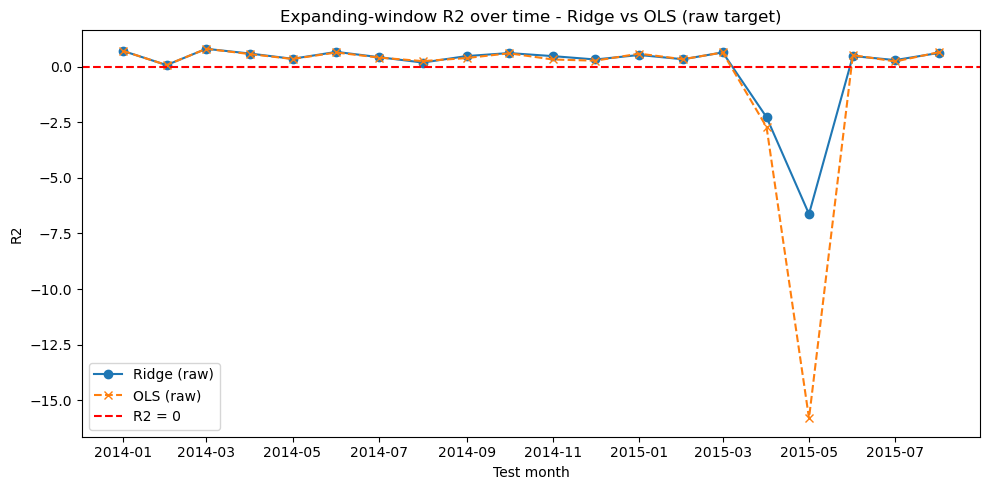

In [ ]:
comparison = pd.DataFrame(
    {
        "Model": ["OLS (raw)", "OLS (log target)", "Ridge (raw)"],
        "Mean_R2": [
            ols_results_raw["R2"].mean(),
            ols_results_log["R2"].mean(),
            ridge_results_raw["R2"].mean(),
        ],
        "Mean_RMSE": [
            ols_results_raw["RMSE"].mean(),
            ols_results_log["RMSE"].mean(),
            ridge_results_raw["RMSE"].mean(),
        ],
        "Mean_MAE": [
            ols_results_raw["MAE"].mean(),
            ols_results_log["MAE"].mean(),
            ridge_results_raw["MAE"].mean(),
        ],
    }
)
display(comparison)

plt.figure(figsize=(10, 5))
plt.plot(
    ridge_results_raw["test_start"],
    ridge_results_raw["R2"],
    marker="o",
    label="Ridge (raw)",
)
plt.plot(
    ols_results_raw["test_start"],
    ols_results_raw["R2"],
    marker="x",
    linestyle="--",
    label="OLS (raw)",
)
plt.axhline(0, color="red", linestyle="--", label="R2 = 0")
plt.title("Expanding-window R2 over time - Ridge vs OLS (raw target)")
plt.xlabel("Test month")
plt.ylabel("R2")
plt.legend()
plt.tight_layout()
plt.show()

Ridge regression improved both stability and overall performance compared to OLS.
The average R2 increased from -0.51 to -0.01 and RMSE and MAE also got slightly better.
Ridge still follows similar monthly patterns as OLS but avoids extreme drops, especially in months where OLS performed very poorly.
This shows that regularization helps the model generalize better and stay more consistent over time.

---

#### Combined - Ridge (log-transformed target)

In [13]:
# Here we combine:
# - a log-transform to stabilize the variance of PM10,
# - Ridge regression to control overfitting and improve stability.


def ridge_model_log(X_train, y_train, X_test, y_test, alphas):
    """Fit and evaluate Ridge regression using choose_alpha_time_series()."""
    best_alpha = choose_alpha_time_series(X_train, y_train, alphas)
    X_train_std, X_test_std, _ = scale_features(X_train, X_test)

    beta = closed_form_regression(X_train_std, y_train, alpha=best_alpha)
    y_pred_log = predict(X_test_std, beta)

    # Back-transform
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test)

    r2, rmse, mae = evaluate_predictions(y_true, y_pred)
    return r2, rmse, mae, best_alpha


# Apply log-transform
y_all_log = np.log1p(y_all)

alphas = np.round(np.logspace(-2, 3, 30), 2)  # range of alphas to test

ridge_results_log, _ = expanding_window_cv(
    X_all, np.log1p(y_all), dates, ridge_model_log, alphas=alphas
)

display(ridge_results_log)

print("\nAverage performance (Ridge, log target):")
print(ridge_results_log[["R2", "RMSE", "MAE"]].mean())

,train_start,train_end,test_start,test_end,R2,RMSE,MAE,alpha
0,2013-01-01,2013-12-31,2014-01-01,2014-01-31,0.671524,9.276128,6.524173,0.01
1,2013-01-01,2014-01-31,2014-02-01,2014-02-28,0.079097,12.562760,9.733355,0.01
2,2013-01-01,2014-02-28,2014-03-01,2014-03-31,0.579839,9.686435,7.870711,137.38
3,2013-01-01,2014-03-31,2014-04-01,2014-04-30,0.563022,6.308831,5.117133,2.59
4,2013-01-01,2014-04-30,2014-05-01,2014-05-31,0.476248,5.170861,4.364137,0.01
5,2013-01-01,2014-05-31,2014-06-01,2014-06-30,0.671462,3.833686,2.952752,5.74
6,2013-01-01,2014-06-30,2014-07-01,2014-07-31,0.570067,3.445897,2.706939,8.53
7,2013-01-01,2014-07-31,2014-08-01,2014-08-31,0.490158,3.504104,2.631729,8.53
8,2013-01-01,2014-08-31,2014-09-01,2014-09-30,0.309451,6.123186,3.865169,3.86
9,2013-01-01,2014-09-30,2014-10-01,2014-10-31,0.538377,8.623955,6.469844,18.87



Average performance (Ridge, log target):
R2      0.349476
RMSE    7.988269
MAE     6.145540
dtype: float64


##### Diagnostics

,Model,Mean_R2,Mean_RMSE,Mean_MAE
0,OLS (raw),-0.507629,8.554018,6.520202
1,OLS (log target),-1.180777,8.890308,6.408090
2,Ridge (raw),-0.013889,8.164906,6.413851
3,Ridge (log target),0.349476,7.988269,6.145540


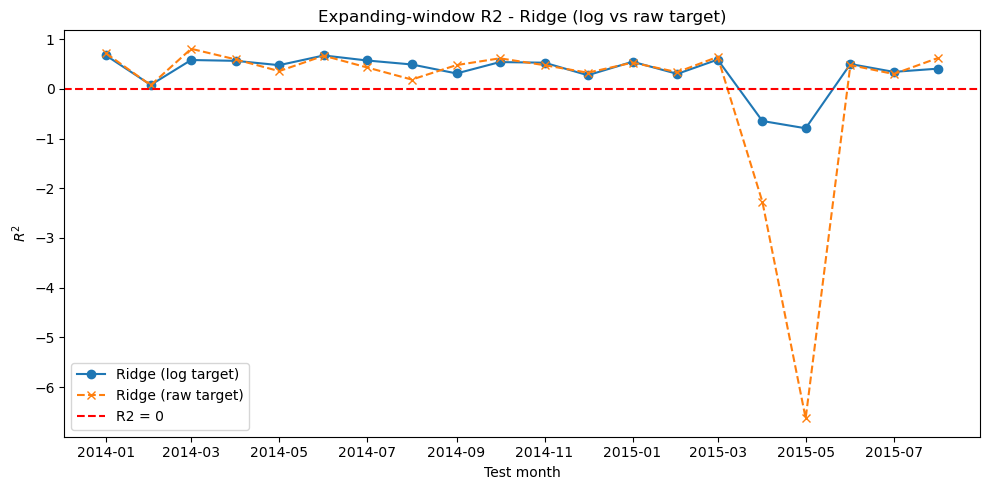

In [14]:
comparison = pd.DataFrame(
    {
        "Model": ["OLS (raw)", "OLS (log target)", "Ridge (raw)", "Ridge (log target)"],
        "Mean_R2": [
            ols_results_raw["R2"].mean(),
            ols_results_log["R2"].mean(),
            ridge_results_raw["R2"].mean(),
            ridge_results_log["R2"].mean(),
        ],
        "Mean_RMSE": [
            ols_results_raw["RMSE"].mean(),
            ols_results_log["RMSE"].mean(),
            ridge_results_raw["RMSE"].mean(),
            ridge_results_log["RMSE"].mean(),
        ],
        "Mean_MAE": [
            ols_results_raw["MAE"].mean(),
            ols_results_log["MAE"].mean(),
            ridge_results_raw["MAE"].mean(),
            ridge_results_log["MAE"].mean(),
        ],
    }
)
display(comparison)

plt.figure(figsize=(10, 5))
plt.plot(
    ridge_results_log["test_start"],
    ridge_results_log["R2"],
    marker="o",
    label="Ridge (log target)",
)
plt.plot(
    ridge_results_raw["test_start"],
    ridge_results_raw["R2"],
    marker="x",
    linestyle="--",
    label="Ridge (raw target)",
)
plt.axhline(0, color="red", linestyle="--", label="R2 = 0")
plt.title("Expanding-window R2 - Ridge (log vs raw target)")
plt.xlabel("Test month")
plt.ylabel("$R^2$")
plt.legend()
plt.tight_layout()
plt.show()

The Ridge model with a log-transformed target worked noticeably better than the others.
The average R2 went up from around -0.01 (Ridge with raw data) to about 0.34, so the model explains a lot more of the variation now.
It’s also much more stable. The extreme negative months are gone and performance stays pretty steady across time.
The log-transform helped handle the large differences in PM10 values and Ridge regularization stopped the model from overfitting.
Together they make the predictions smoother and more reliable than before.

---

#### Nonlinear and interaction features + regularization (Ridge & Lasso)

In [15]:
# This section adds more expressive transformations to the dataset


def ridge_model_advanced(X_train, y_train, X_test, y_test, alphas):
    """Ridge regression with advanced nonlinear and interaction features."""
    # Create feature set
    X_train_adv, X_test_adv = create_advanced_features(X_train, X_test)

    # Choose best alpha
    best_alpha = round(choose_alpha_time_series(X_train_adv, y_train, alphas), 2)

    # Standardize, fit, and predict in log space
    X_train_std, X_test_std, _ = scale_features(X_train_adv, X_test_adv)
    beta = closed_form_regression(X_train_std, y_train, alpha=best_alpha)
    y_pred_log = predict(X_test_std, beta)

    # Back-transform
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test)

    # Evaluate on original scale
    r2, rmse, mae = evaluate_predictions(y_true, y_pred)
    return r2, rmse, mae, best_alpha

In [16]:
def lasso_model_advanced(X_train, y_train, X_test, y_test, alphas):
    """Lasso regression with advanced nonlinear and interaction features."""
    # Expand features safely
    X_train_adv, X_test_adv = create_advanced_features(X_train, X_test)

    # Alpha selection
    best_alpha = choose_alpha_time_series_lasso(X_train_adv, y_train, alphas)

    # Standardize and fit Lasso in log space
    X_train_std, X_test_std, _ = scale_features(X_train_adv, X_test_adv)
    lasso = Lasso(alpha=best_alpha, max_iter=100000, tol=1e-4)
    lasso.fit(X_train_std, y_train)
    y_pred_log = lasso.predict(X_test_std)

    # Back-transform
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_test)

    # Evaluate on original scale
    r2, rmse, mae = evaluate_predictions(y_true, y_pred)
    # n_nonzero = np.sum(lasso.coef_ != 0)

    return r2, rmse, mae, best_alpha

In [17]:
alphas = np.round(np.logspace(-2, 3, 30), 2)  # range of alphas to test
alphas_lasso = np.logspace(-4, 1, 30)

# Ridge
ridge_results_advanced, _ = expanding_window_cv(
    X_all, np.log1p(y_all), dates, ridge_model_advanced, alphas=alphas
)

print("\nAverage performance (Ridge + advanced features):")
print(ridge_results_advanced[["R2", "RMSE", "MAE"]].mean().round(4))

# Lasso
lasso_results_advanced, _ = expanding_window_cv(
    X_all, np.log1p(y_all), dates, lasso_model_advanced, alphas=alphas_lasso
)

print("\nAverage performance (Lasso + advanced features):")
print(lasso_results_advanced[["R2", "RMSE", "MAE"]].mean().round(4))


Average performance (Ridge + advanced features):
R2      0.2757
RMSE    7.2265
MAE     5.4926
dtype: float64


/home/vita/.local/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.496e-02, tolerance: 7.370e-03
  model = cd_fast.enet_coordinate_descent(
/home/vita/.local/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.211e-02, tolerance: 7.370e-03
  model = cd_fast.enet_coordinate_descent(
/home/vita/.local/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.620e-


Average performance (Lasso + advanced features):
R2      0.0526
RMSE    7.7013
MAE     5.6866
dtype: float64


##### Diagnostics

In [18]:
comparison = pd.DataFrame(
    {
        "Model": [
            "OLS (raw)",
            "OLS (log target)",
            "Ridge (raw)",
            "Ridge (log target)",
            "Ridge (advanced nonlinear + log target)",
            "Lasso (advanced nonlinear + log target)",
        ],
        "Mean_R2": [
            ols_results_raw["R2"].mean(),
            ols_results_log["R2"].mean(),
            ridge_results_raw["R2"].mean(),
            ridge_results_log["R2"].mean(),
            ridge_results_advanced["R2"].mean(),
            lasso_results_advanced["R2"].mean(),
        ],
        "Mean_RMSE": [
            ols_results_raw["RMSE"].mean(),
            ols_results_log["RMSE"].mean(),
            ridge_results_raw["RMSE"].mean(),
            ridge_results_log["RMSE"].mean(),
            ridge_results_advanced["RMSE"].mean(),
            lasso_results_advanced["RMSE"].mean(),
        ],
        "Mean_MAE": [
            ols_results_raw["MAE"].mean(),
            ols_results_log["MAE"].mean(),
            ridge_results_raw["MAE"].mean(),
            ridge_results_log["MAE"].mean(),
            ridge_results_advanced["MAE"].mean(),
            lasso_results_advanced["MAE"].mean(),
        ],
    }
)
display(comparison)

,Model,Mean_R2,Mean_RMSE,Mean_MAE
0,OLS (raw),-0.507629,8.554018,6.520202
1,OLS (log target),-1.180777,8.890308,6.408090
2,Ridge (raw),-0.013889,8.164906,6.413851
3,Ridge (log target),0.349476,7.988269,6.145540
4,Ridge (advanced nonlinear + log target),0.275660,7.226508,5.492638
5,Lasso (advanced nonlinear + log target),0.052637,7.701293,5.686600


Ridge with advanced features and log-transformed target turns out to be the most successful.